## Create input se files for CO shell merger ``mppnp_hif`` simulations (Python 3)
This notebook reads in stellar structure data of cycle "model_cycle" from both MESA "profile" and its corresponding ``mppnp`` post-processed se file 
and uses them to generate a parametric CO shell merger model that is written into
a sequence of se files for a number of cycles given by "cycles" variable

Original: ```~/user/scratch14_wendi3/dpa/convreac_setup/write_se_cycles_parametric_COshellmerger.ipynb```

In [2]:
%pylab ipympl   

from nugridpy import nugridse as mp
from nugridpy import mesa as ms
from nugridpy import utils as ut
from nugridpy import ascii_table as at

# uncommitted version that adds self.el_abu_hash and self.el_name  
sys.path.insert(1,"/user/scratch14_wendi3/dpa/NuSE/write_se")
import sewrite as sw

# physical constants
import scipy.constants as sc

from astropy import units as un
from astropy import constants as cc

from scipy.interpolate import Akima1DInterpolator

Populating the interactive namespace from numpy and matplotlib


### Provide path to and cycles "profile" files that contains the 1st and 2nd MESA star models with the O convective shell to read in

#### Right before merger onsets properties

In [108]:
# Ritter+2018 M=15 Z=0.02 model
mesa_dir = "/data/nugrid/data/set1ext/set1.2/see_wind/M15.0Z2.0e-02/LOGS"
model_cycle_1 = 9160

# this model seems to have been used the model used by Jones+2017
# unfortunately, this model turns out to have not been post-processed
#mesa_dir = "/data/ASDR/CSA/Stellar_models/O-shell-M25/M25Z0.02/LOGS"
#model_cycle_1 = 28500

# this seems to be an analogue of Sam's model 
#mesa_dir = "/data/ASDR/NuGrid/data/set1ext/set1.2/see_wind/M25.0Z2.0e-02/LOGS"
#model_cycle_1 = 11000

mesa = ms.mesa_profile(mesa_dir, model_cycle_1)

423 in profiles.index file ...
Found and load nearest profile for cycle 9150
reading profile/data/nugrid/data/set1ext/set1.2/see_wind/M15.0Z2.0e-02/LOGS/log192.data ...
 reading ...100% 

Closing profile tool ...


In [109]:
mass_1 = mesa.get('mass')
tem_1  = 10**mesa.get('logT')
rho_1  = 10**mesa.get('logRho')
deff_1 = 10.**mesa.get('log_D_mix')
rad_1  = 10.**mesa.get('logR')

In [115]:
idx11 = np.argmin(np.abs(mass_1-1.55))
idx12 = np.argmin(np.abs(mass_1-2))

idx21 = np.argmin(np.abs(mass_2-1.55))
idx22 = np.argmin(np.abs(mass_2-2))

In [118]:
(rho_1[idx11] - rho_2[idx21])/rho_1[idx11]

0.03775232044698009

(1.0, 1000000000000000.0)

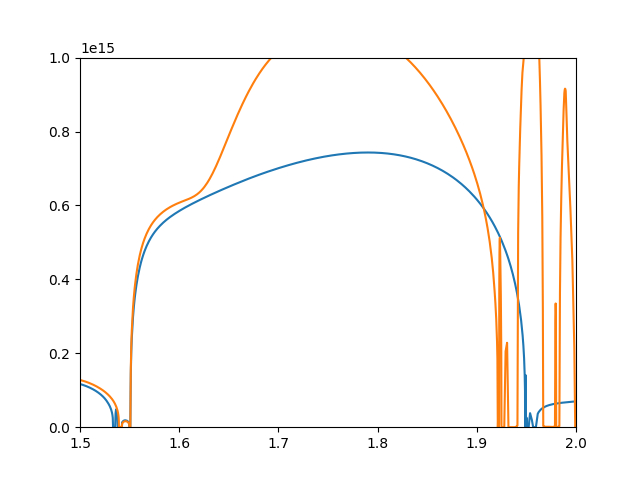

In [121]:
ifig=10; plt.close(ifig);plt.figure(ifig)

plt.plot(mass_1, deff_1)
plt.plot(mass_2, deff_2)
plt.xlim(1.5,2)
plt.ylim(1,1e15)

#### Conditions to write to h5 files

In [110]:
############### Read profile file from mesa_dir

mesa_dir = "/data/nugrid/data/set1ext/set1.2/see_wind/M15.0Z2.0e-02/LOGS"
model_cycle_2 = 9200

#mesa_dir = "/data/ASDR/CSA/Stellar_models/O-shell-M25/M25Z0.02/LOGS"
#model_cycle_2 = 31000

#mesa_dir = "/data/ASDR/NuGrid/data/set1ext/set1.2/see_wind/M25.0Z2.0e-02/LOGS"
#model_cycle_2 = 13000

mesa = ms.mesa_profile(mesa_dir,model_cycle_2)

423 in profiles.index file ...
Found and load nearest profile for cycle 9200
reading profile/data/nugrid/data/set1ext/set1.2/see_wind/M15.0Z2.0e-02/LOGS/log193.data ...
 reading ...100% 

Closing profile tool ...


In [111]:
mass_2 = mesa.get('mass')
rad_2 = 10.**mesa.get('logR')
tem_2 = 10.**mesa.get('logT')
rho_2 = 10.**mesa.get('logRho')
deff_2 = 10.**mesa.get('log_D_mix')
deff_14_2 = (1./14.)*mesa.get('log_D_mix')
xc12_2 = mesa.get('c12')
xo16_2 = mesa.get('o16')
xsi28_2 = mesa.get('si28')

### Create new convective profile based on Jones+2017 O-shell burning
Reference:
> Jones, S., R. Andrassy, S. Sandalski, A. Davis, P. Woodward, and F. Herwig. “Idealized Hydrodynamic Simulations of Turbulent Oxygen-Burning Shell Convection in 4π Geometry.” Monthly Notices of the Royal Astronomical Society 465 (March 1, 2017): 2991–3010. https://doi.org/10.1093/mnras/stw2783.


In [7]:
vmlt   =  np.power(10, mesa.get('log_conv_vel'))
hp     = (mesa.get('pressure_scale_height') * cc.R_sun).cgs.value
radius = (mesa.get('radius') * cc.R_sun).cgs.value

alpha = 1.6
ell = alpha * hp
Dconv_MLT = 1/3 * vmlt * ell

In [8]:
# identify the location of the O-shell

selected_Oshell_mass   = []
selected_Oshell_rho    = []
selected_Oshell_temp   = []
selected_Oshell_radius = []
selected_Oshell_dcoeff = []

i1 = None
found = False
for i in range(len(mass_2)):
    # Selection criteria: 10% Si-28, 10% O-16, convective
    if xsi28_2[i] > 0.1 and xo16_2[i] > 0.1 and deff_2[i] > 1e14:
        
        # identifies the first index
        if not found:
            i1 = i 
            found = True
            
        selected_Oshell_mass  .append(mass_2[i])
        selected_Oshell_radius.append(radius[i]/1e8)
        selected_Oshell_temp  .append(tem_2[i])
        selected_Oshell_rho   .append(rho_2[i])
        selected_Oshell_dcoeff.append(deff_2[i])

# because the indexing starts from the top
iOtop = i1
iObot = i1+len(selected_Oshell_mass)-1

ibot = np.where(mass_2 == selected_Oshell_mass[-1])[0][0]
itop = np.where(mass_2 == selected_Oshell_mass[0])[0][0]

# bottom radial coordinate of the O-shell
r0 = selected_Oshell_radius[-1] * 1e8

imaxD = np.array(list(range(itop,ibot+1)))[ell[itop:ibot+1] > radius[itop:ibot+1] - r0][0]
maxOshellD = deff_2[imaxD]


print ('The top mass coordinate of the O-shell is', selected_Oshell_mass[0],'\nThe bottom mass coordinate of the O-shell is',selected_Oshell_mass[-1],
       '\nThe total mass of the O-shell is',selected_Oshell_mass[0]-selected_Oshell_mass[-1],
       '\nThe total number of mass zones for the O-shell is',len(selected_Oshell_mass))

print('The maximum log10(D_conv) in the O-shell is',np.log10(maxOshellD))

The top mass coordinate of the O-shell is 1.998308198291775 
The bottom mass coordinate of the O-shell is 1.5510274761568053 
The total mass of the O-shell is 0.4472807221349697 
The total number of mass zones for the O-shell is 422
The maximum log10(D_conv) in the O-shell is 15.022376943978259


In [9]:
# These are different because itop-ibot are the actual indices matched 
# whereas iOtop-iObot are the number of indices that match the criteria
print(iOtop, iObot, itop, ibot)

2260 2681 2260 2730


We introduce a flattening point because we actually don't trust the predictions of MLT for the specific shape of the diffusion coefficient profile as it's evolving too rapidly for MLT to be a reliable prediction.

Text(0.5, 0, 'radius (Mm)')

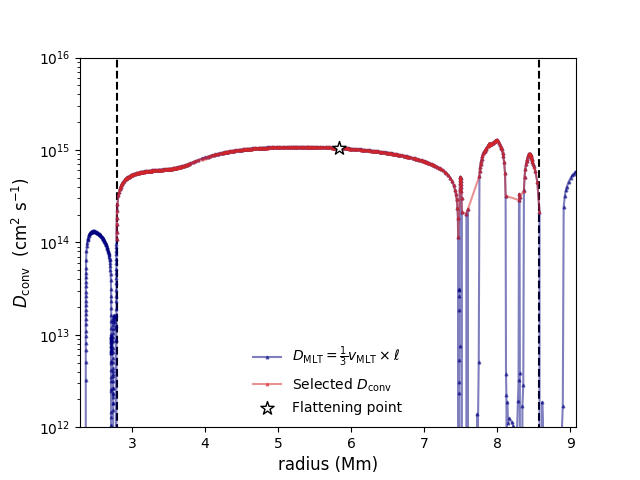

In [10]:
ifig=1;plt.close(ifig);plt.figure(ifig)


plt.semilogy(radius/1e8, Dconv_MLT, zorder=1, color='navy', marker='^', markersize=2, alpha=0.5, label=r'$D_{\mathrm{MLT}} = \frac{1}{3}v_{\mathrm{MLT}}\times\ell$') 

plt.semilogy(selected_Oshell_radius, selected_Oshell_dcoeff, zorder=1, color='tab:red', marker='^', markersize=2, alpha=0.5, label=r'Selected $D_{\mathrm{conv}}$')

plt.scatter(radius[imaxD]/1e8, maxOshellD, marker='*', s=100, edgecolor='black', facecolor='white', label='Flattening point',zorder=100)

vlines(selected_Oshell_radius[0],1e0,1e20,linestyles='dashed', color='black', zorder=1)
vlines(selected_Oshell_radius[-1],1e0,1e20,linestyles='dashed', color='black', zorder=1)
xlim(selected_Oshell_radius[-1] - 0.5, selected_Oshell_radius[0] + 0.5) # M15Z02

plt.legend(frameon=False, loc='lower center')
plt.ylim(1e12, 1e16)
plt.ylabel(r'$D_{\mathrm{conv}} ~~(\mathrm{cm^2~s^{-1}})$', fontsize='large')
plt.xlabel(r'radius (Mm)', fontsize='large')

Jones+2017 say that to calculate a $D_{\mathrm{conv}}$ that qualitatively matches the predictions from PPMstar using the MLT predicted velocities, we should use the following formula.
$$ D_{\mathrm{RCMD}} = v_{\mathrm{MLT}} \times \min(\ell, |r-r_0|) $$
where $r_0$ is the lower radial coordinate of the O-shell.

We will adopt this, but retain a factor of $\frac{1}{3}$ and boost from that. The base case from MLT will be labelled as such, and those following the prescription of Jones+2017 will be labelled with PPM_boost.

In [11]:
Dconv_profiles = {'MLT':   [],
                  'PPM':   [],
                  'PPM3':  [],
                  'PPM10': [],
                  'PPM50': [],
                  'partial':       [],
                  'partial_strong':   [],
                  'gosh': [],
                  'gosh_strong': []}
    

for i in range(itop, ibot+1):
    
    r = radius[i]
    
    # MLT profile
    
    D_mlt = 1/3 * vmlt[i] * ell[i] if (i > imaxD) else maxOshellD
    
    Dconv_profiles['MLT'].append(D_mlt)
    
    # 3-D inspired profile
    
    for boost, key in zip([1, 3, 10, 50], ['PPM', 'PPM3', 'PPM10', 'PPM50']):
        
        D_ppm = np.where(
            i > imaxD, 
            boost * (1/3) * vmlt[i] * np.minimum(ell[i], np.abs(r - r0)), 
            boost * maxOshellD # flatten
        )        
        
        if D_ppm == 0: D_ppm = 1e-99
        
        Dconv_profiles[key].append(D_ppm)
        
    # GOSH profile
    
    def iG(D_mlt, r, a=7.5, w=1/4, c=1e14):
        # 1 - Gaussian
        
        # c - desired depth
        # w - width
        # a - the position
        
        #a = 7.5 # Mm 
        #w = 1/4 # Mm
        #c = 9e14 #cm^2/s
        
        x = r/1e8
        
        q = D_mlt - c
        
        return D_mlt - q*np.exp(-(x-a)**2/w**2)
        
    
    D_partial = iG(D_mlt, r)
    D_partialstrong = iG(D_mlt, r, c=1e13)
    D_gosh = iG(D_mlt, r, a=4.95)
    D_goshstrong = iG(D_mlt, r, a=4.95, c=1e13)

    Dconv_profiles['partial'].append(D_partial)
    Dconv_profiles['partial_strong'].append(D_partialstrong)
    Dconv_profiles['gosh'].append(D_gosh)
    Dconv_profiles['gosh_strong'].append(D_goshstrong)


In [12]:
from nugridpy import utils as ut

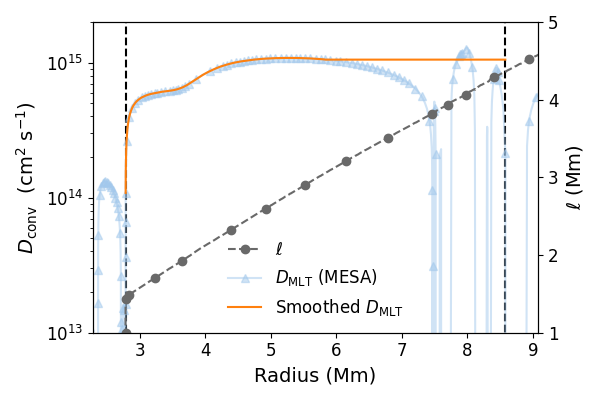

In [114]:
ifig=100;plt.close(ifig);plt.figure(ifig,figsize=(6,4))

ax = plt.gca()

for artist in ax.collections:
    artist.set_rasterized(True)

ax.semilogy(radius/1e8, Dconv_MLT, zorder=1, color=ut.linestylecb(0)[2], marker='^', alpha=0.5, markevery=5, label=r'$D_{\mathrm{MLT}}$ (MESA)') 
ax.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['MLT'], zorder=1, color=ut.linestylecb(1)[2], label=r'Smoothed $D_{\mathrm{MLT}}$')

vlines(selected_Oshell_radius[0],1e0,1e20,linestyles='dashed', color='black', zorder=1)
vlines(selected_Oshell_radius[-1],1e0,1e20,linestyles='dashed', color='black', zorder=1)
xlim(selected_Oshell_radius[-1] - 0.5, selected_Oshell_radius[0] + 0.5) # M15Z02

ax.set_ylim(1e13, 2e15)
ax.set_ylabel(r'$D_{\mathrm{conv}} ~~(\mathrm{cm^2~s^{-1}})$', fontsize=14)
ax.set_xlabel(r'Radius (Mm)', fontsize=14)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

axell = plt.twinx()

axell.plot(radius/1e8, ell/1e8, color='dimgrey', linestyle='dashed', marker='o', markevery=40, label=r'$\ell$')
axell.set_ylim(1, 5)
axell.set_yticks([1,2,3,4,5])
axell.set_ylabel(r"$\ell$ (Mm)",fontsize=14)

axell.tick_params(axis='y', labelsize=12)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = axell.get_legend_handles_labels()

ax.legend(handles2 + handles1, labels2 + labels1, frameon=False, loc='lower center', fontsize=12)

plt.tight_layout()

plt.savefig("Dmlt_forced.pdf", format="pdf", bbox_inches="tight", dpi=300)

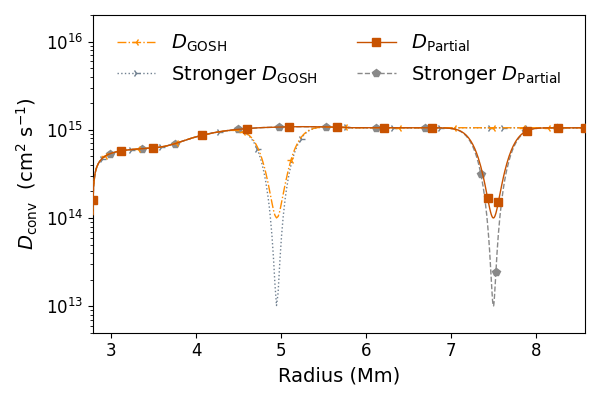

In [96]:
ifig=101;plt.close(ifig);plt.figure(ifig,figsize=(6,4))

#i=1
#plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['MLT'], zorder=5, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
#     color=ut.linestylecb(i)[2],markevery=ut.linestylecb(i,a=20,b=5)[3], lw=3, label=r'$D_{\mathrm{MLT}}$')
i=6
plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['gosh'], zorder=4, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
     color="darkorange",markevery=ut.linestylecb(i,a=35,b=7)[3], lw=1, label=r'$D_{\mathrm{GOSH}}$')
i=7
plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['gosh_strong'], zorder=3, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
     color="slategrey",markevery=ut.linestylecb(i,a=35,b=7)[3], lw=1, label=r'Stronger $D_{\mathrm{GOSH}}$')
i=8
plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['partial'], zorder=4, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
     color=ut.linestylecb(i)[2],markevery=ut.linestylecb(i,a=35,b=7)[3], lw=1, label=r'$D_{\mathrm{Partial}}$')
i=9
plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['partial_strong'], zorder=3, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
     color=ut.linestylecb(i)[2],markevery=ut.linestylecb(i,a=35,b=7)[3], lw=1, label=r'Stronger $D_{\mathrm{Partial}}$')


xlim(selected_Oshell_radius[-1], selected_Oshell_radius[0]) # M15Z02

plt.legend(frameon=False, loc='upper center', ncol=2, fontsize=14)
plt.ylim(5e12, 2e16)
plt.ylabel(r'$D_{\mathrm{conv}} ~~(\mathrm{cm^2~s^{-1}})$', fontsize=14)
plt.xlabel(r'Radius (Mm)', fontsize=14)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax = plt.gca()

for artist in ax.get_children():
    if isinstance(artist, (plt.Line2D)):
        artist.set_rasterized(True)

plt.tight_layout()

plt.savefig("Dmlt_partial_gosh.pdf", format="pdf", bbox_inches="tight", dpi=300)

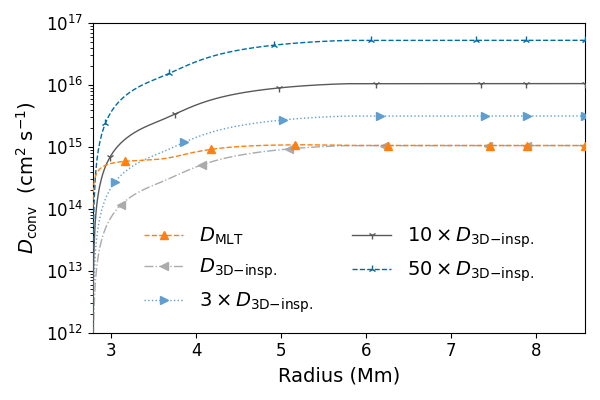

In [94]:
ifig=101;plt.close(ifig);plt.figure(ifig,figsize=(6,4))

i=1
plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['MLT'], zorder=5, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
     color=ut.linestylecb(i)[2],markevery=ut.linestylecb(i,a=70,b=7)[3], lw=1, label=r'$D_{\mathrm{MLT}}$')
i=2
plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['PPM'], zorder=4, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
     color=ut.linestylecb(i)[2],markevery=ut.linestylecb(i,a=70,b=7)[3], lw=1, label=r'$D_{\mathrm{3D\mathrm{-}insp.}}$')
i=3
plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['PPM3'], zorder=3, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
     color=ut.linestylecb(i)[2],markevery=ut.linestylecb(i,a=70,b=7)[3], lw=1, label=r'$3\times D_{\mathrm{3D\mathrm{-}insp.}}$')
i=4
plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['PPM10'], zorder=4, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
     color=ut.linestylecb(i)[2],markevery=ut.linestylecb(i,a=70,b=7)[3], lw=1, label=r'$10\times D_{\mathrm{3D\mathrm{-}insp.}}$')
i=5
plt.semilogy(radius[itop:ibot+1]/1e8, Dconv_profiles['PPM50'], zorder=3, ls=ut.linestylecb(i)[0], marker=ut.linestylecb(i)[1],  \
     color=ut.linestylecb(i)[2],markevery=ut.linestylecb(i,a=70,b=7)[3], lw=1, label=r'$50\times D_{\mathrm{3D\mathrm{-}insp.}}$')


xlim(selected_Oshell_radius[-1], selected_Oshell_radius[0]) # M15Z02

plt.legend(frameon=False, loc='lower center', ncol=2, fontsize=14)
plt.ylim(1e12, 1e17)
plt.ylabel(r'$D_{\mathrm{conv}} ~~(\mathrm{cm^2~s^{-1}})$', fontsize=14)
plt.xlabel(r'Radius (Mm)', fontsize=14)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax = plt.gca()

for artist in ax.get_children():
    if isinstance(artist, (plt.Line2D)):
        artist.set_rasterized(True)

plt.tight_layout()

plt.savefig("Dmlt_downturn.pdf", format="pdf", bbox_inches="tight", dpi=300)

In [14]:
print('MLT log10(Dconv):', np.log10(Dconv_profiles['MLT'][-4:][::-1]))
print('PPM-inspired log10(Dconv):', np.log10(Dconv_profiles['PPM'][-4:][::-1]))

MLT log10(Dconv): [14.03546494 14.11370231 14.19824787 14.26582164]
PPM-inspired log10(Dconv): [-99.          10.79353517  11.34101432  11.68431433]


### Interpolation

Now, we will interpolate the data so that it's on an equi-distant mass grid with resolution turned up as the bottom of the convective boundary to properly capture the behaviour there so that we can write it out into SE files for mppnp to use. This step is important to do explicitly because the output data in MESA is definitely not equi-distant.

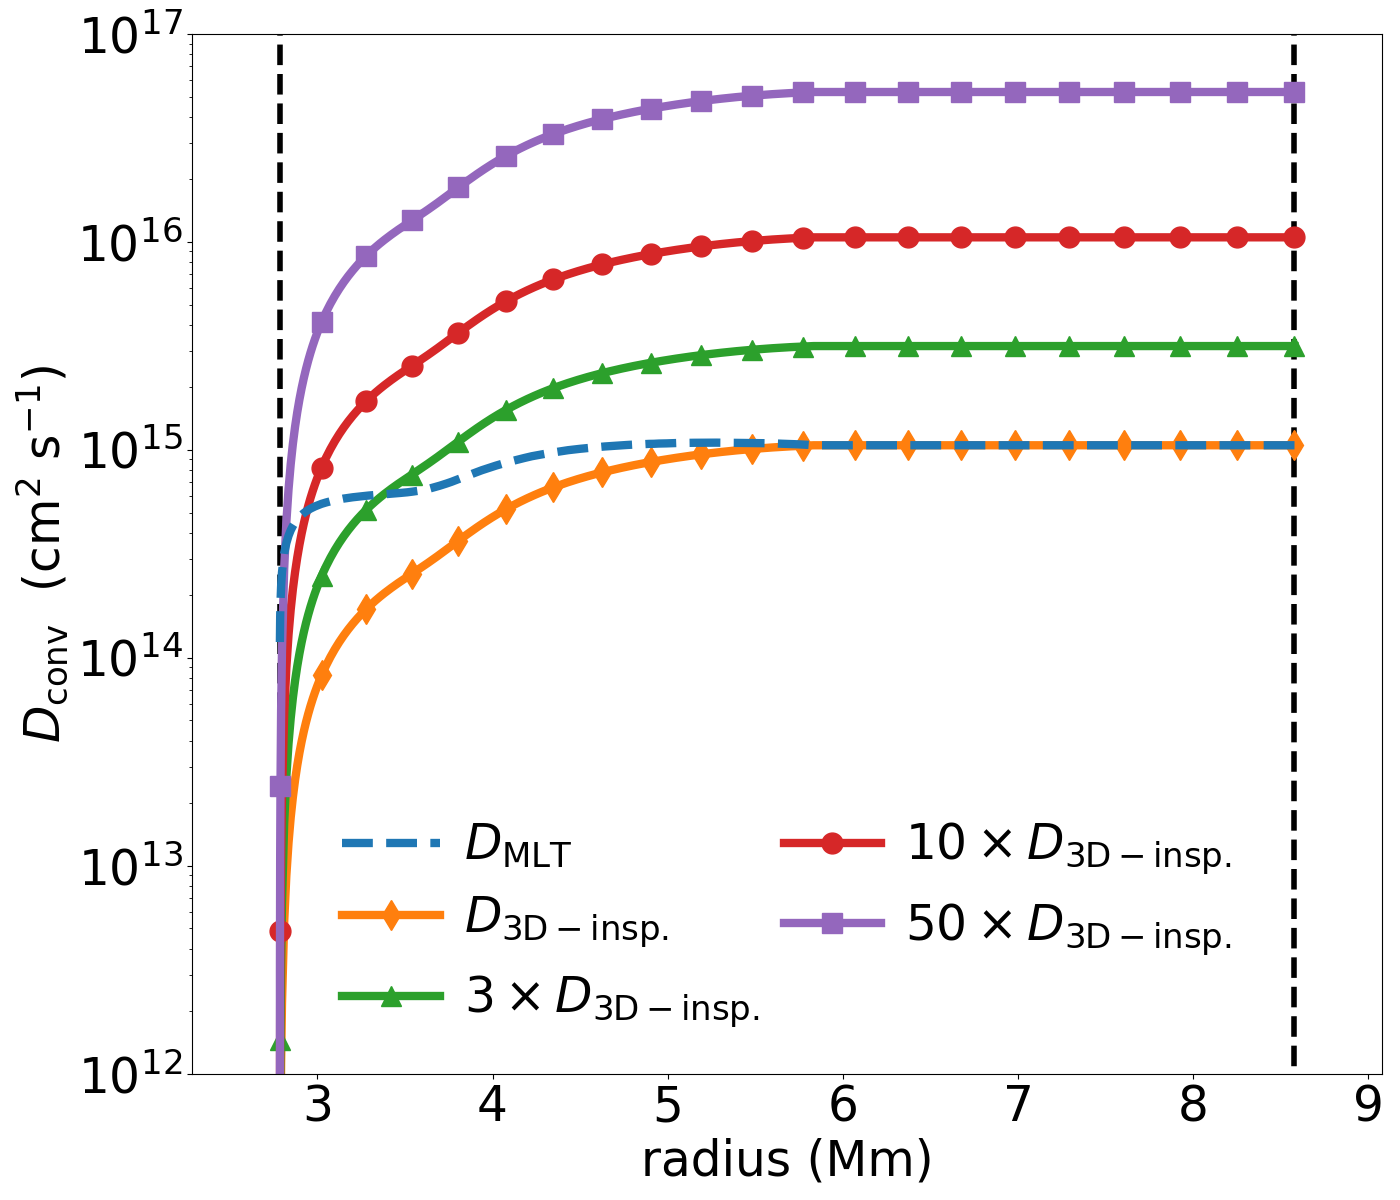

In [43]:
ifig=3;plt.close(ifig);plt.figure(ifig, figsize=(14,12))

for case, linestyle, marker, color, zorder, label in zip(['MLT', 'PPM', 'PPM3', 'PPM10', 'PPM50'],
                                                         ['--', 'solid', 'solid', 'solid', 'solid'],
                                                         ['None', 'd', '^', 'o', 's'],
                                                         ['tab:blue', 'tab:orange', 'tab:green', 'tab:red','tab:purple'],
                                                         [2,1,1,1,1],
                                                         [r'$D_{\mathrm{MLT}}$', r'$D_{\mathrm{3D-insp.}}$', r'$3\times D_{\mathrm{3D-insp.}}$', r'$10\times D_{\mathrm{3D-insp.}}$', r'$50\times D_{\mathrm{3D-insp.}}$']
                                                        ):

#for case, linestyle, marker, color, zorder, label, lw in zip(['MLT', 'partial', 'partial_strong', 'gosh', 'gosh_strong'],
#                                                             ['--', 'solid', 'solid', 'solid', 'solid'],
#                                                             ['None', 'o', 'None', '^','None'],
#                                                             ['tab:blue','tab:brown','mediumturquoise','tab:pink','lime'],
#                                                             [2,2,1,2,1],
#                                                             [r'$D_{\mathrm{MLT}}$', r'$D_{\mathrm{Partial}}$', r'Deeper $D_{\mathrm{Partial}}$', r'$D_{\mathrm{GOSH-like}}$', r'Deeper $D_{\mathrm{GOSH-like}}$'],
#                                                             [6,3,6,3,6]
#                                                            ):
 
    Dconv_selected = Dconv_profiles[case]

    equi_mass_grid = np.linspace(mass_2[ibot], mass_2[itop], num=400)
    # the resolution is going to be turned up at the bottom of the array (note we have to flip it so that it will be monotonically increasing with index; same deal with the Akima interpolator)
    extras = (np.array(selected_Oshell_mass[::-1])[np.array(selected_Oshell_mass[::-1]) < equi_mass_grid[1]])
    equi_mass_grid = np.concatenate((extras, equi_mass_grid[1:]))

    rho_interp    = Akima1DInterpolator(mass_2[itop:ibot+1][::-1], rho_2[itop:ibot+1][::-1])(equi_mass_grid)
    temp_interp   = Akima1DInterpolator(mass_2[itop:ibot+1][::-1], tem_2[itop:ibot+1][::-1])(equi_mass_grid)
    dcoeff_interp = Akima1DInterpolator(mass_2[itop:ibot+1][::-1], Dconv_selected[::-1])(equi_mass_grid)
    radius_interp = Akima1DInterpolator(mass_2[itop:ibot+1][::-1], radius[itop:ibot+1][::-1])(equi_mass_grid)
    
    mass_O = equi_mass_grid[::-1]
    tem_O  = temp_interp[::-1]
    deff_O = dcoeff_interp[::-1]
    rho_O  = rho_interp[::-1]
    rad_O  = radius_interp[::-1]
    
    plt.semilogy(rad_O/1e8, deff_O, zorder=zorder, color=color, lw=lw, markersize=15, markevery=20, linestyle=linestyle, label=label, marker=marker) 


vlines(selected_Oshell_radius[0],1e0,1.5e17,linestyles='dashed', color='black', zorder=1, lw=4)
vlines(selected_Oshell_radius[-1],1e0,1.5e17,linestyles='dashed', color='black', zorder=1, lw=4)
xlim(selected_Oshell_radius[-1] - 0.5, selected_Oshell_radius[0] + 0.5) # M15Z02

#plt.legend(frameon=False, loc='upper center', ncol=2, fontsize=35, handletextpad=0.5, columnspacing=0.5)
plt.legend(frameon=False, loc='lower center', ncol=2, fontsize=35, handletextpad=0.5, columnspacing=0.5)
#plt.ylim(5e12, 8e15)
plt.ylim(1e12,1e17)
plt.ylabel(r'$D_{\mathrm{conv}} ~~(\mathrm{cm^2~s^{-1}})$', fontsize=35)
plt.xlabel(r'radius (Mm)', fontsize=35)


plt.xticks(fontsize=35)
plt.yticks(fontsize=35)


ax = plt.gca()


for artist in ax.get_children():
    if isinstance(artist, (plt.Line2D)):
        artist.set_rasterized(True)

plt.tight_layout()

plt.savefig("All_Dconv.pdf", format="pdf", bbox_inches="tight", dpi=300)

In [51]:
# select which diffusion coefficient profile we will be considering from now on here
"""
SELECT MIXING CASE RIGHT NOW
"""
Dconv_selected = Dconv_profiles['gosh_strong']

equi_mass_grid = np.linspace(mass_2[ibot], mass_2[itop], num=400)
# the resolution is going to be turned up at the bottom of the array (note we have to flip it so that it will be monotonically increasing with index; same deal with the Akima interpolator)
extras = (np.array(selected_Oshell_mass[::-1])[np.array(selected_Oshell_mass[::-1]) < equi_mass_grid[1]])
equi_mass_grid = np.concatenate((extras, equi_mass_grid[1:]))

rho_interp    = Akima1DInterpolator(mass_2[itop:ibot+1][::-1], rho_2[itop:ibot+1][::-1])(equi_mass_grid)
temp_interp   = Akima1DInterpolator(mass_2[itop:ibot+1][::-1], tem_2[itop:ibot+1][::-1])(equi_mass_grid)
dcoeff_interp = Akima1DInterpolator(mass_2[itop:ibot+1][::-1], Dconv_selected[::-1])(equi_mass_grid)
radius_interp = Akima1DInterpolator(mass_2[itop:ibot+1][::-1], radius[itop:ibot+1][::-1])(equi_mass_grid)

In [52]:
# you have to flip this around for mppnp
mass_O = equi_mass_grid[::-1]
tem_O  = temp_interp[::-1]
deff_O = dcoeff_interp[::-1]
rho_O  = rho_interp[::-1]
rad_O  = radius_interp[::-1]

print('The number of mass zones prepared for the SE files is', len(mass_O)) 

The number of mass zones prepared for the SE files is 404


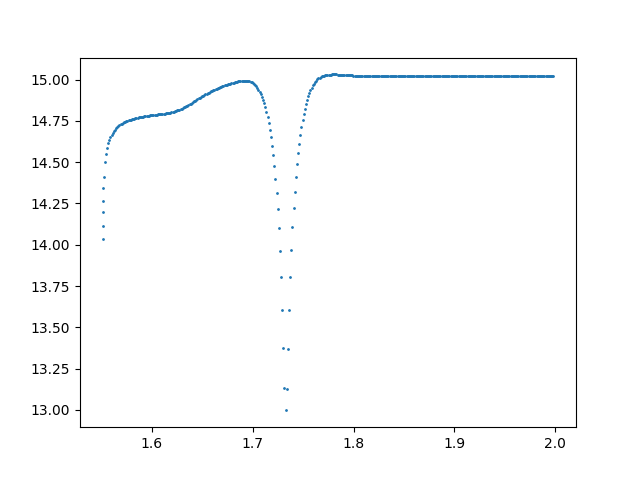

In [53]:
ifig=199999;plt.close(ifig);plt.figure(ifig)

plt.scatter(mass_O, np.log10(deff_O), s=1)

Compare the interpolated values with the MESA profiles at the cycle right before the onset of merger (note that the diffusion coefficient profile will be a bit different because it increase as the merger onsets). This is a thing to keep in mind because we are grabbing the species from the pre-onset model and using the stellar structure of the just-as-onset model.

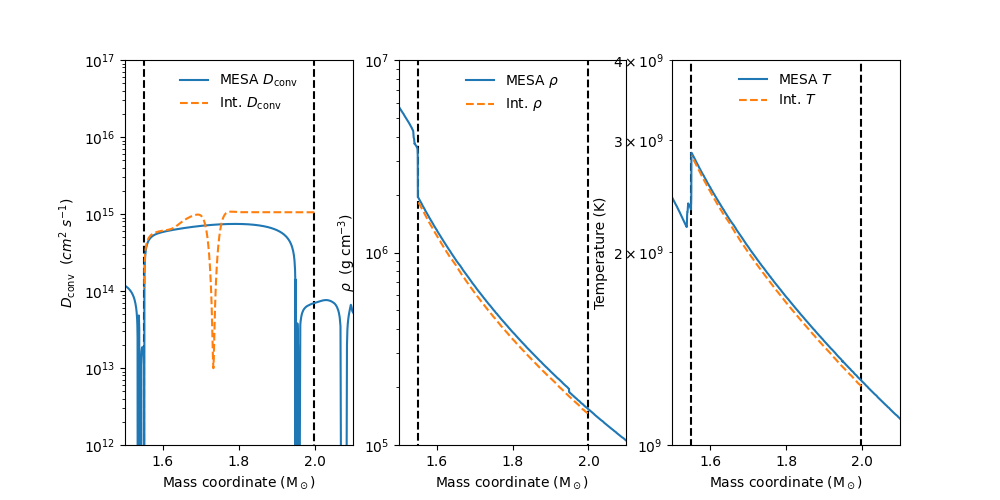

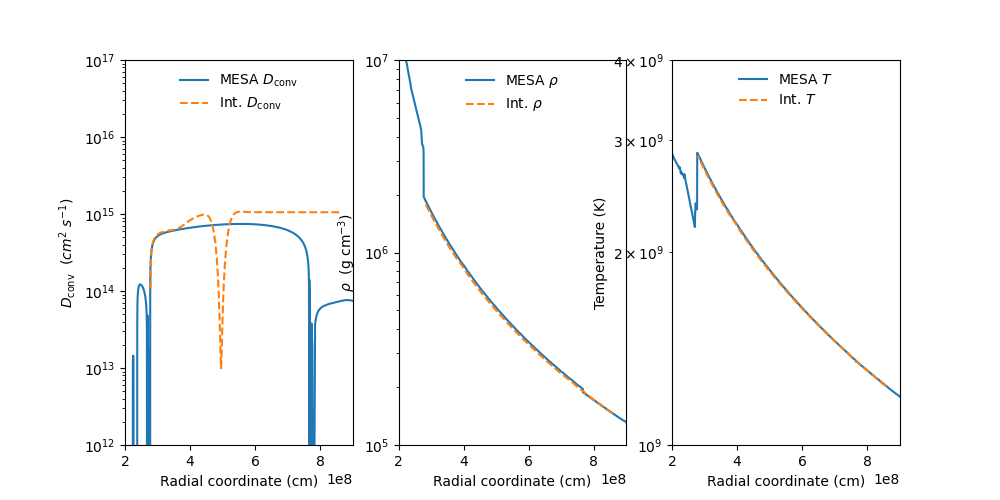

In [54]:
ifig=4;plt.close(ifig);

fig, axs = plt.subplots(1,3,num=ifig,sharex=True,figsize=(10,5))

axs[0].set_ylabel(r'$D_{\mathrm{conv}} ~~(cm^2~s^{-1})$')
axs[0].semilogy(mass_1, deff_1, label='MESA $D_{\mathrm{conv}}$')
axs[0].semilogy(mass_O, deff_O, linestyle='--', label='Int. $D_{\mathrm{conv}}$', zorder=2)
axs[0].set_ylim(1e12, 1e17)

axs[1].set_ylabel(r'$\rho ~~(\mathrm{g}~\mathrm{cm}^{-3})$')
axs[1].semilogy(mass_1, rho_1, label=r'MESA $ \rho $')
axs[1].semilogy(mass_O, rho_O, linestyle='--', label=r'Int. $ \rho $ ', zorder=2)
axs[1].set_ylim(1e5, 1e7)

axs[2].set_ylabel(r'Temperature (K)')
axs[2].semilogy(mass_1, tem_1, label='MESA $T$')
axs[2].semilogy(mass_O, tem_O, linestyle='--', label='Int. $T$', zorder=2)
axs[2].set_ylim(1e9, 4e9)


for ax in axs:
    ax.vlines(mass_O[0],1e-1,1e20, color='black',linestyles='--')
    ax.vlines(mass_O[-1],1e-1,1e20, color='black',linestyles='--')
    ax.legend(frameon=False, loc='upper center')
    ax.set_xlabel(r'Mass coordinate ($\mathrm{M_\odot}$)')
    ax.set_xlim(1.5,2.1) # M15Z02
    #xlim(1.15,1.92) # Sam's M25Z02
    #xlim(1.4,3.0) # M25Z02
    
ifig=5;plt.close(ifig);

fig, axs = plt.subplots(1,3,num=ifig,sharex=True,figsize=(10,5))

axs[0].set_ylabel(r'$D_{\mathrm{conv}} ~~(cm^2~s^{-1})$')
axs[0].semilogy((rad_1* cc.R_sun).cgs.value, deff_1, label='MESA $D_{\mathrm{conv}}$')
axs[0].semilogy(rad_O, deff_O, linestyle='--', label='Int. $D_{\mathrm{conv}}$', zorder=2)
axs[0].set_ylim(1e12, 1e17)

axs[1].set_ylabel(r'$\rho ~~(\mathrm{g}~\mathrm{cm}^{-3})$')
axs[1].semilogy((rad_1* cc.R_sun).cgs.value, rho_1, label=r'MESA $ \rho $')
axs[1].semilogy(rad_O, rho_O, linestyle='--', label=r'Int. $ \rho $ ', zorder=2)
axs[1].set_ylim(1e5, 1e7)

axs[2].set_ylabel(r'Temperature (K)')
axs[2].semilogy((rad_1* cc.R_sun).cgs.value, tem_1, label='MESA $T$')
axs[2].semilogy(rad_O, tem_O, linestyle='--', label='Int. $T$', zorder=2)
axs[2].set_ylim(1e9, 4e9)


for ax in axs:
    ax.vlines(rad_O[0] * cc.R_sun.value / 1e6,1e-1,1e20, color='black',linestyles='--')
    ax.vlines(rad_O[-1] * cc.R_sun.value / 1e6,1e-1,1e20, color='black',linestyles='--')
    ax.legend(frameon=False, loc='upper center')
    ax.set_xlabel(r'Radial coordinate (cm)')
    ax.set_xlim(2e8,9e8) # M15Z02
    #xlim(1.15,1.92) # Sam's M25Z02
    #xlim(1.4,3.0) # M25Z02

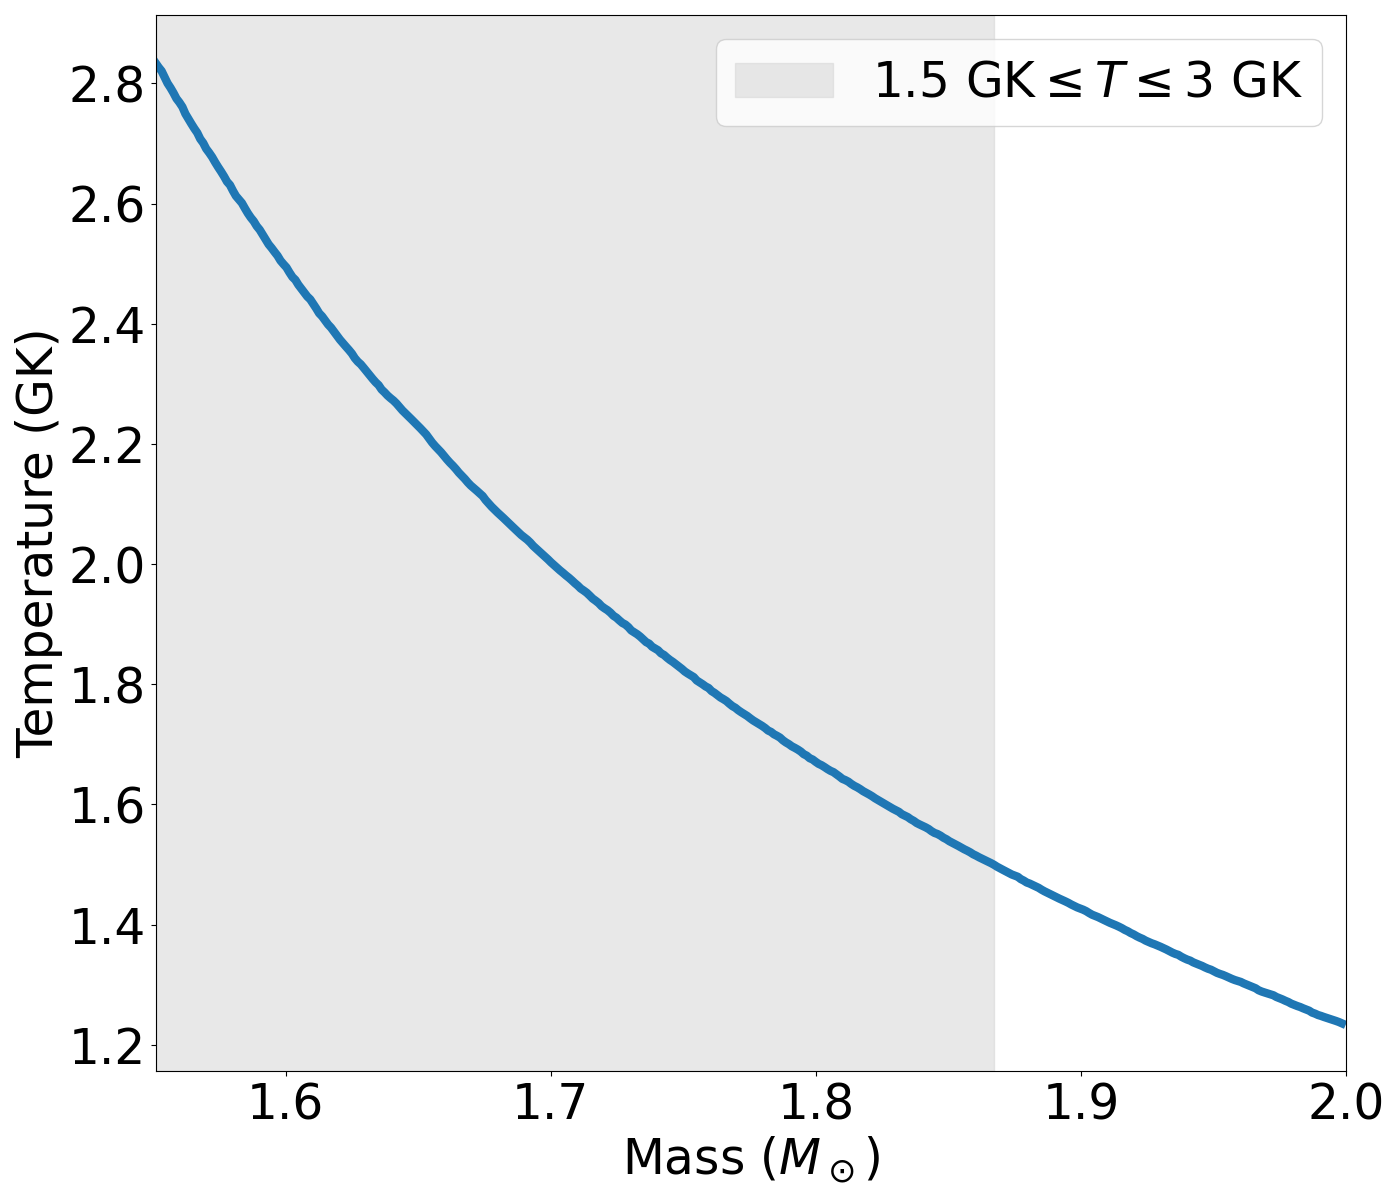

In [74]:
ifig = 10000
plt.close(ifig)
plt.figure(ifig, figsize=(14, 12))

plt.plot(mass_O, tem_O / 1e9, lw=6, zorder=2)

ileft = np.argmin(np.abs(tem_O / 1e9 - 1.5))  # Index where temperature is closest to 1.5 GK
iright = np.argmax(tem_O)  # Index where temperature is maximum

plt.axvspan(mass_O[ileft], mass_O[iright], color='lightgrey', alpha=0.5, zorder=1, label=r'$1.5~\mathrm{GK} \leq T \leq 3~\mathrm{GK}$')
plt.ylabel('Temperature (GK)', fontsize=35)
plt.xlabel(r'Mass ($M_\odot$)', fontsize=35)
plt.xlim(mass_O[-1], mass_O[0])
plt.xticks([1.6,1.7,1.8,1.9,2.0],fontsize=35)
plt.yticks(fontsize=35)

plt.legend(loc='upper right', fontsize=35, frameon=True)

ax = plt.gca()
for artist in ax.get_children():
    if isinstance(artist, plt.Line2D):
        artist.set_rasterized(True)
        
plt.tight_layout()

plt.savefig("Temperature_Profile.pdf", format="pdf", bbox_inches="tight", dpi=300)

### Provide path to the corresponding ``mppnp`` post-processed se file 

In [21]:
mppnp_dir = "/data/ASDR/NuGrid/data/set1ext/set1.2/ppd_wind/M15.0Z2.0e-02/H5_out"
pt=mp.se(mppnp_dir)

Searching files, please wait.......
Reading preprocessor files
File search complete.


 reading ['iso_massf']...100%

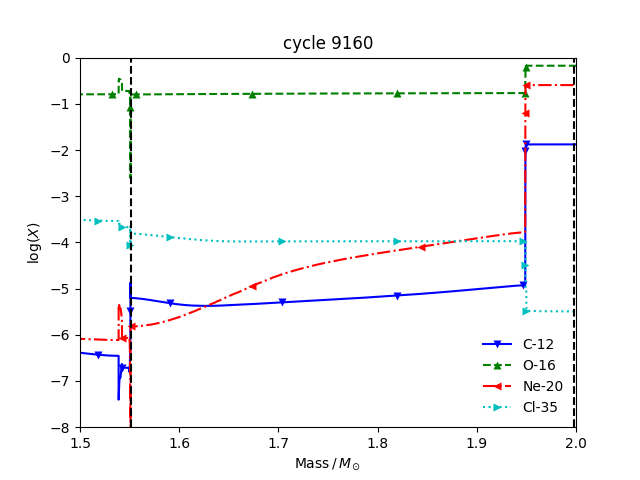

In [22]:
species = ['C-12', 'O-16', 'Ne-20', 'Cl-35']
ifig=6;plt.close(ifig);plt.figure(ifig)

# select one of the two models from which the initial composition of 
# the O-shell and C-ingested material will be used in the post-processing simulations
model_cycle = model_cycle_1 
plot_cycle = model_cycle

title('cycle ' + str(plot_cycle))
pt.abu_profile(isos=species, ifig=ifig, fname=plot_cycle, logy=True)
ylim(-8,0)
xlim(1.5,2)

#axvline(mass_2[iOtop], color='black', linestyle='dashed')
#axvline(mass_2[iObot], color='black', linestyle='dashed')
axvline(mass_O[0], color='black', linestyle='dashed')
axvline(mass_O[-1], color='black', linestyle='dashed')


#xlim(0.0,7)
legend(frameon=False,loc=4)

### Select mass coordinates in the ``mppnp`` model from where to read in the initial isotopic abundances for the O and C shells 

In [23]:
mCshell = 2.0
mOshell = 1.8
#mCshell = 2.9
#mOshell = 2.2
pt.abund_at_masscoordinate(model_cycle,mCshell)
pt.abund_at_masscoordinate(model_cycle,mOshell)

 reading ['rho']...100%]...100%iso_massf
 reading ['rho']...100%]...100%iso_massf
 reading ['iso_massf']...100%

In [24]:
# use the isotopic abundances in the C shell to prepare a cshell_abund.ppn file with abundances ingested by the O shell 
ppn_file = 'massf_'+str(mCshell)+'.dat'
print (ppn_file)

f1=open(ppn_file)
lines=f1.readlines()
f1.close()

massfrac=[]
Z=[]
element = []
AI = []

nskip = 5

for k in range(len(lines)):
    # skip header
    if k < nskip:
        continue
    
    line=lines[k]
    el = line[2:4].strip()
    if len(el) > 1: 
        el = el.replace(el[-1],el[-1].lower())
    A = int(line[5:10].strip())
    AI.append(A) # A integer
  
    Z.append(ut.get_z_from_el(el)) # Z
    el = el.lower()
    if el == 'h' and A == 1:
        el = 'PROT'
    element.append(el) # element (execept NEUT (first) and PROT (second)) 
    massfrac.append("{:.10e}".format(float(line[11:-1].strip()))) # massf

# ppn file output
fout=open('../cshell_abund.ppn','w')

for ie in range(len(AI)):
    el = element[ie]
    nsp = 5-len(el)-len(str(AI[ie]))
    sps = nsp*" "
    iso_out = el+sps+str(AI[ie])
    if int(Z[ie]) == 1 and int(AI[ie]) == 1:
        iso_out = "PROT "
    nsp = 3-len(str(Z[ie]))
    z_out = nsp*" "+str(Z[ie])
    line_out = z_out+" "+iso_out+9*" "+str(massfrac[ie])+"\n"
    #line_out = " " + str(Z[ie]) + " " + element[ie] + " " + str(AI[ie]) + " " + str(massfrac[ie]) + "\n"
    fout.write(line_out)
fout.close()

massf_2.0.dat


In [25]:
# prepare abundance arrays that will be used to make the first restart file for the O shell
ppn_file = 'massf_'+str(mOshell)+'.dat'
print (ppn_file)

f1=open(ppn_file)
lines=f1.readlines()
f1.close()

massfrac=[]
Z=[]
element = []
AI = []

nskip = 5

for k in range(len(lines)):
    # skip header
    if k < nskip:
        continue
    
    line=lines[k]
    el = line[2:4].strip()
    if len(el) > 1: 
        el = el.replace(el[-1],el[-1].lower())
    A = int(line[5:10].strip())
    AI.append(A) # A integer
  
    Z.append(ut.get_z_from_el(el)) # Z
    el = el.lower()
    if el == 'h' and A == 1:
        el = 'PROT'
    element.append(el) # element (execept NEUT (first) and PROT (second)) 
    massfrac.append("{:.10e}".format(float(line[11:-1].strip()))) # massf

massf_1.8.dat


### Take the abundances you want to use in mppnp from the MESA profile

In [26]:
species=['neut', 'h1', 'h2', 'he3', 'he4', 'li7', 'b8', 'c12', 'c13', 'n13', 'n14', 'n15',\
         'o15', 'o16', 'o17', 'o18', 'f17', 'f18', 'f19', 'f20', 'ne18', 'ne19', 'ne20', 'ne21', 'ne22',\
         'na20', 'na21', 'na22', 'na23', 'mg22', 'mg23', 'mg24', 'mg25', 'mg26', 'al24', 'al25', 'al26', 'al27',\
         'si27', 'si28', 'si29', 'si30', 'si31', 'p30', 'p31', 'p32', 'p33', 's31', 's32', 's33', 's34', 's35', 'cl35', 'cl37',\
         'ar36', 'ar37', 'ar38', 'k39', 'ca40', 'ca42', 'sc45', 'ti46', 'fe56']

species=['neut', 'h1', 'he3', 'he4', 'c12', 'n14', 'o16', 'ne20', 'mg24', 'si28', 's32', 'ar36', 'ca40', 'fe56']

In [27]:
abu= []
NName = []
A = []
for spec in species[1:]:
    abu.append(mesa.get(spec))
    ilet=""; clet=""    # analyse name, extract
    for let in spec:    # capitalized element name
        if let.isdigit():   # and mass number
            ilet = ilet+let
        else:
            clet = clet+let
    NName.append(ut.get_z_from_el(clet.capitalize()))
    A.append(int(ilet))
abus = {}
for uname in set(NName):
    abus[uname] = {}
for i,spec in enumerate(species[1:]):
    #rint(i,spec,NName[i],A[i])
    abus[NName[i]][A[i]]=abu[i]

print (abus[8][16][iOtop],abus[8][16][iObot])

0.46815366537681086 0.1664316012941449


In [28]:
Msun = 1e3*cc.M_sun.value
Rsun = 1e2*cc.R_sun.value
print('Msun =',Msun,', Rsun =',Rsun)

Msun = 1.988409870698051e+33 , Rsun = 69570000000.0


In [29]:
print ( 1.998308198291775 * Msun / 1e27 )
print ( (1.998308198291775 - 1.8) * Msun / 1e27 ) 
print ( (mass_2[iOtop] - mass_2[iObot]) * Msun / 1e27 )

print( 0.05 * Msun/1e27 )

3973455.7461802033
394317.97892371163
813200.5763148527
99420.49353490256


In [30]:
# these stellar structure arrays have to be flipped, otherwise mppnp will not run with them

print (len(mass_O),mass_O[0],mass_O[-1])

#rhot, tempt, mass, dcoeff, radius = [np.flip(rho_O),np.flip(tem_O),np.flip(mass_O), np.flip(deff_O),np.flip(rad_O)]

nt = len(mass_O)
rhot = linspace(0,0,nt)
tempt = linspace(0,0,nt)
mass = linspace(0,0,nt)
dcoefft = linspace(0,0,nt)
radiust = linspace(0,0,nt)

for i in range(nt):
    rhot[i] = float(rho_O[i])/1e3
    tempt[i] = float(tem_O[i])/1e9
    mass[i] = float(mass_O[i])*(Msun/1e27)
    dcoefft[i] = float(deff_O[i])
    
    # DOUBLE CHECK IF YOU AREN'T JOSH ISSA
    
    radiust[i] = float(rad_O[i])*(1/1e8)

delta_mass = - np.diff(mass)
# mppnp doesn't work if any delta_mass = 0, therefore insert delta_mass[1] to delta_mass[0]
# the insert is needed to make dimensions of mass and delta_mass equal 
delta_mass = np.insert(delta_mass,0,delta_mass[1])
#delta_mass = np.flip(delta_mass)
print (len(delta_mass),delta_mass[0],delta_mass[-1])

mtot = mass[0]-mass[-1]
print (mtot)

masst = mass
delta_masst = delta_mass

404 1.998308198291775 1.5510274761568053
404 2229.0160472830757 125.66149963391945
889377.402866126


In [31]:
print ((mass[-18]-mass[-1])*(1e27/1.989e33),(mass[-18]-mass[-1])/(mass[0]-mass[-1]))

0.01456873233518631 0.03258145363408495


In [32]:
8.353e+30/1e27

8353.0

### The se and restart files will be generated in the following directory it will be cleaned first, therefore check that a directory with this name that contains an mportant data doesn't exist in the current directory

In [33]:
stellar_structure_folder = '/user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/'

In [34]:
!rm -rf "$stellar_structure_folder" && mkdir "$stellar_structure_folder"

In [35]:
# carefully check these parameters, they will be used in the post-processing
z_ini = 0.02
mass_ini = 15.0 # the initial mass of the model
#mass_ini = 25.0 # the initial mass of the model
time_pp = 110 # post-processing time (in s) estimated with the notebook plot_pprocess.ipynb
#time_pp = 1000 # 440 # post-processing time (in s) estimated with the notebook plot_pprocess.ipynb
dt_pp = 0.01 #0.01 #0.5 # post-processing time step (in s)
#dt_pp = 1.0 # post-processing time step (in s)
nmod_pp = int(time_pp/dt_pp) + 100
"""
INGESTION RATE IS SUPER IMPORTANT!
"""
dmdtC = 1e-3 # 1e-4 # 1e-5 # 0.0 # 1e-3 # C-ingestion rate (in solar masses per s) estimated with the notebook plot_pprocess.ipynb
entrate = dmdtC*(Msun/1e27)
print ('N_mod =',nmod_pp,', entrate =',entrate)

N_mod = 11100 , entrate = 1988.4098706980508


In [36]:
if dmdtC > 0.:
    print ((mass_O[-20]-mass_O[-1])/(dmdtC*dt_pp))

1681.5064741916074


In [37]:
# this cell will just print the names of the SE files that will actually
# be created in the next cell and it will also generate an *.idx file
# that is necessary for mppnp runs

# this is the total number of mppnp cycles
N_mod = nmod_pp

hif_dir = stellar_structure_folder

# chose from which model number to start
cycle0 = 0 # 5000
hif_file = 'my_test_hif.'+str(cycle0+1).zfill(7)+'.se.h5'

# each SE file will contain nc cycles
nc = 100
ni = int((N_mod+nc)//nc)+1
cycle_one = 1
cycles=range(cycle0+cycle_one,cycle0+(ni*nc)+1) 

#print cycles

file_idx_out=hif_dir+"my_test_hif.idx"
fout_idx=open(file_idx_out,'w')
fout_idx.write(hif_file+"\n")

cycle_bndy=[cycle0+1]
outputfiles=[hif_dir+'my_test_hif.'+str(cycle_bndy[-1]).zfill(7)+'.se.h5']

for i in range(ni):
    cycle_bndy.append(cycle_bndy[-1]+nc)
    line_idx_out = 'my_test_hif.'+str(cycle_bndy[-1]).zfill(7)+'.se.h5'
    outputfiles.append(hif_dir+'my_test_hif.'+str(cycle_bndy[-1]).zfill(7)+'.se.h5')  
    #print (outputfiles[i])
    if i < ni-1:
        fout_idx.write(line_idx_out+"\n")
fout_idx.close()

print ("The next cell will generate se output files from")
print (outputfiles[0])
print ("to")
print (outputfiles[-1])
print ("and my_test_hif.idx file")

The next cell will generate se output files from
/user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/my_test_hif.0000001.se.h5
to
/user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/my_test_hif.0011301.se.h5
and my_test_hif.idx file


In [38]:
############### Write out model_cycle for each cycle of cycles

#from tables import *

# chose from which model number to starat
cycle0 = 0 # 5000
nc = 100
ni = int((N_mod+nc)//nc)+1
cycle_one = 1
cycles=range(cycle0+cycle_one,cycle0+(ni*nc)+1) 

#print cycles

hif_dir = stellar_structure_folder

cycle_bndy=[cycle0+1]
outputfiles=[hif_dir+'my_test_hif.'+str(cycle_bndy[-1]).zfill(7)+'.se.h5']

for i in range(ni):
    cycle_bndy.append(cycle_bndy[-1]+nc)
    outputfiles.append(hif_dir+'my_test_hif.'+str(cycle_bndy[-1]).zfill(7)+'.se.h5')                       

i=0

# writing global parameters:

# make sure that you write the right units to ensure that mppnp will compute with the right values.

hattr_name = ["codev", "modname", "mini", "zini", "rotini", "overini", "age_unit",
        "mass_unit", "radius_unit", "rho_unit", "temperature_unit",
        "dcoeff_unit","firstcycle"]
hattr_data = ['MES', 'modname', mass_ini, z_ini, 0., 0., 1., 1e27, 1e8, 1e3, 1e9, 1., cycles[0]]


shellnb, age, deltat, entrate = [len(masst),0.,dt_pp,entrate] 

for cyc in cycles:
    cyc = int(cyc)
    if cyc==cycle_bndy[i]:
        print ("start writing in file ",outputfiles[i])
        file_sewrite=sw.startfile(outputfiles[i])
        file_sewrite.write_hattr(hattr_name,hattr_data)
        # Add specific header info about first cycle
        file_sewrite.write_hattr(hattr_name=['firstcycle'],hattr_val=[np.array([cyc], dtype=np.int32)])
        i+=1

#write h5 cycle data
    #write data columns
    dcol_name = ["rho", "temperature", "mass", "dcoeff", "radius", "delta_mass"]
    dcol_data = [rhot, tempt, masst, dcoefft, radiust, delta_masst]
    #file_sewrite.write_dcol(cycles[i], dcol_name, dcol_data)
    file_sewrite.write_dcol(cyc, dcol_name, dcol_data)

    #write data attributes
    cattr_name = ["total_mass", "shellnb", "age", "deltat","entrate"]
    cattr_data = [mtot,shellnb,age,deltat,entrate]
    #file_sewrite.write_cattr(cycles[i], cattr_name, cattr_data)
    file_sewrite.write_cattr(cyc, cattr_name, cattr_data)
    age+=deltat

start writing in file  /user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/my_test_hif.0000001.se.h5
start writing in file  /user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/my_test_hif.0000101.se.h5
start writing in file  /user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/my_test_hif.0000201.se.h5
start writing in file  /user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/my_test_hif.0000301.se.h5
start writing in file  /user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/my_test_hif.0000401.se.h5
start writing in file  /user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/my_test_hif.0000501.se.h5
start writing in file  /user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_gosh_strong_400/my_test_hif.0000601.se.h5
start writing in file  /user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_

## Prepare mass fractions for the restart file

In [39]:
#### Create .restart.h5 file (with one cycle)

# abundance template data are read from a ppn output that was obtained
# for the isotopebase.txt with either 1107 or 5234 species

f1=open('/user/scratch14_wendi3/dpa/convreac_setup/input_data/initcomp_mesafehm2.6_1107.DAT')
#f1 = open('/user/scratch14_csa/jissa/COshellmergers/coshellmerger_josh/notebooks/cshell_abund.ppn')

lines=f1.readlines()
f1.close()

massfrac_tmp = []
shells_massfrac_tmp=[]
A_tmp=[]
Z_tmp=[]
mass_tmp=[]

print ("\n There are", len(lines), "isotopes in the file")

for k in range(len(lines)):
    # skip header
    if k<7:
        continue
    isotopes=[]
    line=lines[k]
    idx_iso=[]
    isotopes1=[]
    #print line
    strk = line.split()
    Z_tmp.append(int(float(strk[1])))
    A_tmp.append(int(float(strk[2])))
    # for PopIII stars we assume that all mass fraction are 1e-99
    # except theose for the selected MESA isotopes that are added afterwards
    massfrac_tmp.append('1.00000E-99')

# here we add the mass fractions for the selected MESA isotopes
mass_int = 0.5*(masst[0]+masst[-1])

shells_massfrac_tmp = [[1e-99 for i in range(len(massfrac_tmp))] for k in range(len(masst))]

# use abundances in the O shell available from the MESA "profile" file
#for k in range(len(masst)):
#    for i in range(len(massfrac_tmp)):
#        if Z_tmp[i] in list(abus.keys()) and A_tmp[i] in list((abus.get(Z_tmp[i])).keys()):
#            # we are in a convective zone, use abundances at the middle of the zone
#                shells_massfrac_tmp[k][i]=abus[Z_tmp[i]][A_tmp[i]][int(0.5*(iOtop+iObot))]

# use abundances in the O shell from the corresponding mppnp se file 
k = 0
for i in range(len(massfrac_tmp)):
    for j in range(len(AI)):
        if int(Z_tmp[i]) == int(Z[j]) and int(A_tmp[i]) == AI[j]:
            shells_massfrac_tmp[k][i] = massfrac[j]
            
for k in range(len(masst)):
    for i in range(len(massfrac_tmp)):
        shells_massfrac_tmp[k][i] = shells_massfrac_tmp[0][i]
                
# Assume no isomeric states!!!:
isomeric_state_tmp=[1]*len(Z_tmp)

#i = 16
#for k in range(len(masst)):
#    print (k, i, masst[k], shells_massfrac_tmp[k][i], dcoefft[k])


 There are 1100 isotopes in the file


In [40]:
massfrac[int((np.where(np.array(Z) == 6) and np.where(np.array(AI) == 12))[0])]

'6.6523965521e-06'

In [41]:
###### Write restart cycle #########

hif_dir = stellar_structure_folder

name='my_test_hif.0000001.restart.h5'

f=sw.startfile(hif_dir+name)

cattr_name_restart = ["total_mass", "shellnb", "age"]
cattr_data_restart = [mtot,shellnb,0]

# Same header as in se files
print(hattr_name+['zisnb'])
f.write_hattr(hattr_name=hattr_name+['zisnb'],hattr_val=hattr_data+[len(shells_massfrac_tmp[0])])

# A,Z, isomeric state, mass,iso_massf is all needed in restart file (except header)

f.write_table('A',A_tmp)
f.write_table('Z',Z_tmp)
f.write_table('isomeric_state',isomeric_state_tmp)

#f.write_dcol(1,dcol_name, dcol_data)

##### WHY ABUNDANCES ARE FLIPPED????

f.write_dcol(1,dcol_name=['mass']+['iso_massf'],dcol_val=[np.flip(masst)]+[np.flip(shells_massfrac_tmp,0)])

# write column attr,really needed: "shellnb", but write out more,e.g. age
f.write_cattr(1,cattr_name=cattr_name_restart,cattr_val=cattr_data_restart)

['codev', 'modname', 'mini', 'zini', 'rotini', 'overini', 'age_unit', 'mass_unit', 'radius_unit', 'rho_unit', 'temperature_unit', 'dcoeff_unit', 'firstcycle', 'zisnb']


In [42]:
import h5py

with h5py.File("/user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_MLT_400/my_test_hif.0000101.se.h5", 'r') as openfile:
        
    reading = openfile['cycle-101/SE_DATASET']
    
    print(reading[:5])


[(1.05287532e+15, 2229.01604728, 3973455.7461802 , 8.57833945, 146.09367927, 1.23582493)
 (1.05287532e+15, 2229.01604728, 3971226.73013292, 8.5617966 , 146.68769651, 1.23799778)
 (1.05287532e+15, 2229.01604728, 3968997.71408564, 8.54525505, 147.24437827, 1.23978873)
 (1.05287532e+15, 2229.01604728, 3966768.69803835, 8.52871555, 147.77595564, 1.24137681)
 (1.05287532e+15, 2229.01604728, 3964539.68199107, 8.5121821 , 148.29736943, 1.24292872)]


In [43]:
import h5py

with h5py.File("/user/scratch14_wendi3/jissa/OC_runs/stellar_structure_data_dt001_PPM3_400/my_test_hif.0000101.se.h5", 'r') as openfile:
        
    reading = openfile['cycle-101/SE_DATASET']
    
    print(reading[:5])


[(3.15862595e+15, 2229.01604728, 3973455.7461802 , 8.57833945, 146.09367927, 1.23582493)
 (3.15862595e+15, 2229.01604728, 3971226.73013292, 8.5617966 , 146.68769651, 1.23799778)
 (3.15862595e+15, 2229.01604728, 3968997.71408564, 8.54525505, 147.24437827, 1.23978873)
 (3.15862595e+15, 2229.01604728, 3966768.69803835, 8.52871555, 147.77595564, 1.24137681)
 (3.15862595e+15, 2229.01604728, 3964539.68199107, 8.5121821 , 148.29736943, 1.24292872)]
